In [1]:
#uncomment this if you are not using puffer
import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

#my university container always require reinstalling these dependencies; uncomment this if you don't need to
!pip install -U spacy
!pip install torchtext
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We are using ", device)

import numpy as np
import spacy

import operator
import random
import math
import time

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

     |████████████████████████████████| 13.9 MB 12.5 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     |████████████████████████████████| 19.1 MB 12.2 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
We are using  cuda


## 5 - TorchText + biGRU + Attention + Beam Search Decoding + Packed Padded Sequences + Masking + BLEU

## Introduction

In this notebook we will be adding one improvement - beam search decoding.  Decoding based on the most probable words may not always be the best.  Allowing the network to try different possible paths may able to yield better sentences.  That is the idea of beam search decoding, i.e., parallely finding good sentences.

This is edited from https://github.com/shawnwun/NNDIAL.

Everything is almost similar to previous tutorials so I will skip most instructions.

## 1. Preprocessing

### Load the dataset

In [2]:
from torchtext.datasets import Multi30k

SRC_LANGUAGE = 'de'
TRG_LANGUAGE = 'en'
train_iter, valid_iter, test_iter = Multi30k(split=('train', 'valid', 'test'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

In [3]:
len(train_iter)

29000

In [4]:
#let's try print one train sample
#a pair of src sentence (de) and target sentence (en)
sample = next(train_iter)
sample

('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.\n',
 'Two young, White males are outside near many bushes.\n')

### Tokenizers

In [5]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [6]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [7]:
#example of tokenization of the english part
print("English sentence: ", sample[1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](sample[1]))

English sentence:  Two young, White males are outside near many bushes.

Tokenization:  ['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '\n']


In [8]:
# helper function to yield list of tokens
def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

In [9]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

In [10]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [11]:
#see some example
vocab_transform[TRG_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[2208, 11, 4, 0, 4]

In [12]:
len(vocab_transform[TRG_LANGUAGE])

6192

### Batch Iterator

In [13]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch


In [14]:
from torchtext.data.functional import to_map_style_dataset

train_iter, valid_iter, test_iter = Multi30k(split=('train', 'valid', 'test'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

#if we simply use train_iter, once we run it, it cannot be iterate more, so let's convert to map style dataset
train_dataset = to_map_style_dataset(train_iter)
valid_dataset = to_map_style_dataset(valid_iter)
test_dataset = to_map_style_dataset(test_iter)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_fn)

In [15]:
src, _, trg = next(iter(train_loader))
print("src shape: ", src.shape) # (seq len, batch_size)
print("trg shape: ", trg.shape) # (seq len, batch_size)  #if you like batch size first, simply set batch_first = True

src shape:  torch.Size([25, 64])
trg shape:  torch.Size([26, 64])


## 2. Building the Seq2Seq Model

### Encoder

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        #embedded = [src len, batch size, emb dim]
                
        #need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'), enforce_sorted=False)
                
        packed_outputs, hidden = self.rnn(packed_embedded)        
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

In [17]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
    
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        #hidden = [batch size, src len, enc hid dim]        

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2)))
        #energy = [batch size, src len, dec hid dim]
        
        attention = self.v(energy).squeeze(2)
        #attention = [batch size, src len]

        attention = attention.masked_fill(mask == 0, -1e10)
        #attention = [batch size, src len]

        return F.softmax(attention, dim = 1)

### Decoder

In [18]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
                
        #simply the SOS_IDX for all batches
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
        #a = [batch size, src len]

        a = a.unsqueeze(1)
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        #embedded = [batch size, emb dim]
        
        output = output.squeeze(0)
        #output = [batch size, dec hid dim * n directions]
        
        weighted = weighted.squeeze(0)
        #weighted = [batch size, enc hid dim * 2]

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)
        #prediction = [batch size, output dim]
        #hidden = [batch size, dec hid dim]
        #a = [batch size, src len]

### Seq2Seq

Here we shall add three methods, the <code>decode</code> method which is simply a factory function that route to greedy decoding or beam search decoding.  The greedy decoding is quite straightforward.  As for the beam search, we are using PriorityQueues which attempts to only retrieve some top nodes with the highest probabilities.  Using PriorityQueues relieve us from implementing many boiler code for deciding which node has the highest probabilities.

Another difference is that beam_search_decoding has to be done sentence by sentence, thus the batch size is indexed and reduced to only 1.  To keep the dimension same, we unsqueeze 1 dimension for the batch size.

Note that beam width is a crucial factor.  In industry, 10 is often used.   Anyhow, it is important to normalize the score of node by the length (for more details, read https://arxiv.org/abs/1808.10006).   

The code otherwise is mostly self-explanatory.

In [19]:
from queue import PriorityQueue

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)  #permute so it's the same shape as attention
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is the probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.5 we use teacher forcing 50% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)
        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs
    
    def decode(self, src, src_len, trg, method='beam-search'):
        
        #src = [src len, batch size]
        #src len = [batch size]

        encoder_outputs, hidden = self.encoder(src, src_len) 
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
       
        hidden = hidden.unsqueeze(0)
        #hidden = [1, batch size, dec hid dim]
        
        if method == 'beam-search':
            return self.beam_decode(src, trg, hidden, encoder_outputs)
        else:
            return self.greedy_decode(trg, hidden, encoder_outputs)

    def greedy_decode(self, trg, decoder_hidden, encoder_outputs):
        seq_len, batch_size = trg.size()
        decoded_batch = torch.zeros((batch_size, seq_len))
        decoder_input = Variable(trg.data[0, :]).cuda()  # SOS_IDX
        for t in range(seq_len):
            decoder_output, decoder_hidden, _ = self.decoder(decoder_input, decoder_hidden, encoder_outputs)

            topv, topi = decoder_output.data.topk(1)
            topi = topi.view(-1)
            decoded_batch[:, t] = topi

            decoder_input = topi.detach().view(-1)

        return decoded_batch

    def beam_decode(self, src_tensor, target_tensor, decoder_hiddens, encoder_outputs=None):
        #src_tensor = [src len, batch size]
        #target_tensor = [trg len, batch size]
        #decoder_hiddens = [1, batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        target_tensor = target_tensor.permute(1, 0)
        #target_tensor = [batch size, trg len]
        
        #how many parallel searches
        beam_width = 10
        
        #how many sentence do you want to generate
        topk = 1  
        
        #final generated sentence
        decoded_batch = []
                
        # decoding goes sentence by sentence
        for idx in range(target_tensor.size(0)):  # batch_size
            
            #decoder_hiddens = [1, batch size, dec hid dim]
            decoder_hidden = decoder_hiddens[:, idx, :] #.unsqueeze(0)
            #decoder_hidden = [1, dec hid dim]  #because we index, that dimension is gone
            
            #encoder_outputs = [src len, batch size, enc hid dim * 2]
            encoder_output = encoder_outputs[:, idx, :].unsqueeze(1)
            #encoder_output = [src len, 1, enc hid dim * 2]
            
            mask = self.create_mask(src_tensor[:, idx].unsqueeze(1))
            # print("mask shape: ", mask.shape)
            
            #mask = [1, src len]

            # Start with the start of the sentence token
            decoder_input = torch.LongTensor([SOS_IDX]).to(device)

            # Number of sentence to generate
            endnodes = []
            number_required = min((topk + 1), topk - len(endnodes))

            # starting node -  hidden vector, previous node, word id, logp, length
            node = BeamSearchNode(decoder_hidden, None, decoder_input, 0, 1)
            nodes = PriorityQueue()

            # start the queue
            nodes.put((-node.eval(), node))
            qsize = 1

            # start beam search
            while True:
                # give up when decoding takes too long
                if qsize > 2000: break

                # fetch the best node
                # score is log p divides by the length scaled by some constants
                score, n = nodes.get()
                
                # wordid is simply the numercalized integer of the word
                decoder_input = n.wordid
                decoder_hidden = n.h

                if n.wordid.item() == EOS_IDX and n.prevNode != None:
                    endnodes.append((score, n))
                    # if we reached maximum # of sentences required
                    if len(endnodes) >= number_required:
                        break
                    else:
                        continue

                # decode for one step using decoder
                # decoder_input = SOS_IDX
                # decoder_hidden = [1, dec hid dim]
                # encoder_outputs = [src len, 1, enc hid dim * 2]
                # mask = [batch size, src len]
                decoder_output, decoder_hidden, _ = self.decoder(decoder_input, decoder_hidden, encoder_output, mask)

                # PUT HERE REAL BEAM SEARCH OF TOP
                log_prob, indexes = torch.topk(decoder_output, beam_width)
                nextnodes = []  #the next possible node you can move to

                # we only select beam_width amount of nextnodes
                for new_k in range(beam_width):
                    decoded_t = indexes[0][new_k].view(-1)
                    log_p = log_prob[0][new_k].item()

                    node = BeamSearchNode(decoder_hidden, n, decoded_t, n.logp + log_p, n.len + 1)
                    score = -node.eval()
                    nextnodes.append((score, node))

                # put them into queue
                for i in range(len(nextnodes)):
                    score, nn = nextnodes[i]
                    nodes.put((score, nn))
                    # increase qsize
                qsize += len(nextnodes) - 1

            # Once everything is finished, choose nbest paths, back trace them
            if len(endnodes) == 0:
                endnodes = [nodes.get() for _ in range(topk)]

            utterances = []
            for score, n in sorted(endnodes, key=operator.itemgetter(0)):
                utterance = []
                utterance.append(n.wordid)
                # back trace
                while n.prevNode != None:
                    n = n.prevNode
                    utterance.append(n.wordid)

                utterance = utterance[::-1]
                utterances.append(utterance)

            decoded_batch.append(utterances)

        return decoded_batch
    
class BeamSearchNode(object):
    def __init__(self, hiddenstate, previousNode, wordId, logProb, length):
        self.h = hiddenstate  #define the hidden state
        self.prevNode = previousNode  #where does it come from
        self.wordid = wordId  #the numericalized integer of the word
        self.logp = logProb  #the log probability
        self.len = length  #the current length

    def eval(self, alpha=0.7):
        # the score will be simply the log probability normalized by the length 
        # we add some small number to avoid division error
        # read https://arxiv.org/abs/1808.10006 to understand how alpha is selected
        return self.logp / float(self.len + 1e-6) ** (alpha)
    
    #this is the function for comparing between two beamsearchnodes, whether which one is better
    #it is called when you called "put"
    #the__  denotes that this function is inherent with anything that is of "object" type
    def __lt__(self, other):
        return self.len < other.len

    def __gt__(self, other):
        return self.len > other.len

### 3. Training the Seq2Seq Model

In [20]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

In [21]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8015, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(6192, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=6192, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 21,172,528 trainable parameters


In [23]:
optimizer = optim.Adam(model.parameters())

In [24]:
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [25]:
def train(model, loader, optimizer, criterion, clip):
    
    model.train()
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        #put them to GPU
        src = src.to(device)
        trg = trg.to(device)
        #src = [src len, batch size]
        #trg = [src len, batch size]
        #src_len = [batch size]

        #clear gradients
        optimizer.zero_grad()
        
        #make prediction
        output = model(src, src_len, trg)
        #output = [trg len, batch size, output dim]
        
        #remove the first output (SOS) and then reshape both output and trg so we can calculate loss
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        #calculate loss and update
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

Here, we are calling our implemented beam-search function <code>decode</code>.  To show it, we print some sample so we can take a look.

In [26]:
def evaluate(model, loader, criterion):
    
    model.eval()
    epoch_loss = 0
    decoded_batch_list = []

    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            #put them to GPU
            src = src.to(device)
            trg = trg.to(device)
            #src = [src len, batch size]
            #trg = [src len, batch size]
            #src_len = [batch size]

            #turn off teacher forcing
            #make prediction
            output = model(src, src_len, trg, 0) 
            #output = [trg len, batch size, output dim]

            #decoding using beam_search as example (you don't need to put here, because beam_search is for intference)
            decoded_batch = model.decode(src, src_len, trg, method='beam-search')
            decoded_batch_list.append(decoded_batch)
            
            #remove the first output (SOS) and then reshape both output and trg so we can calculate loss
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
        #this is optional; you don't have to; printing first three examples
        print("print samples from first decode batch")
        for sentence_index in decoded_batch_list[0][:3]:
            decode_text_arr = [vocab_transform[TRG_LANGUAGE].lookup_token(i) for i in sentence_index[0]]
            decode_sentence = " ".join(decode_text_arr[1:-1])
            print("pred target : {}".format(decode_sentence))
        
    return epoch_loss / len(loader)

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
N_EPOCHS = 10
CLIP = 1

train_losses = []
valid_losses = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

print samples from first decode batch
pred target : A <unk> in a a in a a a a .
pred target : A child in a blue and and a a a a a .
pred target : A woman and a a a a a a a in a in in the background .
Epoch: 01 | Time: 1m 21s
	Train Loss: 4.658 | Train PPL: 105.477
	 Val. Loss: 4.319 |  Val. PPL:  75.090
print samples from first decode batch
pred target : A young child is a red ball ball .
pred target : A man is his hands while he is standing in the the of the ocean .
pred target : Three large dogs are in the snow in the snow .
Epoch: 02 | Time: 1m 19s
	Train Loss: 3.425 | Train PPL:  30.726
	 Val. Loss: 3.633 |  Val. PPL:  37.812
print samples from first decode batch
pred target : A group of <unk> walk down the street with their flags .
pred target : Kids are riding in a amusement park .
pred target : A brown dog jumps jumping with a yellow ball in its mouth .
Epoch: 03 | Time: 1m 19s
	Train Loss: 2.762 | Train PPL:  15.836
	 Val. Loss: 3.378 |  Val. PPL:  29.318
print samples from fir

In [29]:
model.load_state_dict(torch.load('tut5-model.pt'))
test_loss = evaluate(model, test_loader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

print samples from first decode batch
pred target : A man is scrapping some trees .
pred target : Young man is on a skateboard , holding his cellphone .
pred target : A man and boy boy on a rocky beach .
| Test Loss: 3.214 | Test PPL:  24.868 |


Text(0, 0.5, 'loss')

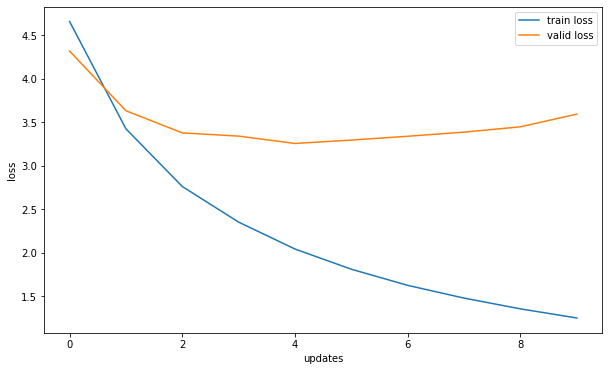

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

## 4. Inference - Beam Search

Here, in inference, we shall use beam search instead of argmax.  Instead of using the highest probability word right away, we simply call our <code>decode</code> method.

In [31]:
def translate_sentence_beam_search(src_sentence, trg_sentence, model, device, max_len = 50):

    model.eval()
    src_tensor = text_transform[SRC_LANGUAGE](src_sentence)
    # src_tensor = [src len]

    trg_tensor = text_transform[SRC_LANGUAGE](trg_sentence)
    # trg_tensor = [trg len]

    src_len = torch.tensor([len(src_tensor)])
    # src_len = [1]
    
    src_tensor = torch.LongTensor(src_tensor).unsqueeze(1).to(device)
    # src_tensor = [src len, 1]

    trg_tensor = torch.LongTensor(trg_tensor).unsqueeze(1).to(device)
    # trg_tensor = [trg len, 1]

    with torch.no_grad():
        decoded_batch = model.decode(src_tensor, src_len, trg_tensor, method='beam-search')
        
    #there is only one sentence, so index 0
    for i in decoded_batch[0]:
        decode_text_arr = [vocab_transform[TRG_LANGUAGE].lookup_token(j) for j in i]
                    
    return decode_text_arr[1:-1]

In [32]:
valid_iter = Multi30k(split=('valid'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))
sample = next(valid_iter)

In [33]:
#de
src_sentence = sample[0]
src_sentence = src_sentence.rstrip("\n")
src_sentence

'Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen'

In [34]:
#en
trg_sentence = sample[1]
trg_sentence = trg_sentence.rstrip("\n")
trg_sentence

'A group of men are loading cotton onto a truck'

In [35]:
translation = translate_sentence_beam_search(src_sentence, trg_sentence, model, device)
print(f'predicted trg = {translation}')

predicted trg = ['A', 'group', 'of', 'men', 'are', 'hanging', 'out', 'on', 'a', 'truck', '.']


## BLEU

Here, we can use beam_search decoding to see whether our BLEU increases.

In [36]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(iterator, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for src, trg in iterator:
        
        pred_trg = translate_sentence_beam_search(src, trg, model, device, max_len)
        
        #tokenize target sentence so it can be compared with pred_trgs
        trg = token_transform[TRG_LANGUAGE](trg.rstrip("\n"))

        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
        # print("pred_trg: ", pred_trg)
        # print("trg: ", trg)

    return bleu_score(pred_trgs, trgs)

We get a BLEU of around 31.11 which is better than our previous tutorial (30).  Note that BLEU score is very sensitive to beam width.  Read this https://arxiv.org/pdf/1808.10006.pdf for more details.

In [37]:
test_iter = Multi30k(split=('test'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))
bleu_score = calculate_bleu(test_iter, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 31.11


In the next tutorials we will be trying non-recurrent version by using convolutional network.  It is quite competitive in terms of performance but can be run much faster because it is not sequential.